### Iowa Liquor Sales 

In [1]:
from collections import defaultdict
import datetime
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
plt.rcParams['figure.figsize'] = 10, 10

%matplotlib inline

In [2]:
df = pd.read_csv('Iowa_Liquor_sales_sample_10pct.csv')
df.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,11/04/2015,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,$4.50,$6.75,12,$81.00,9.0,2.38
1,03/02/2016,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,Tin Cup,750,$13.75,$20.63,2,$41.26,1.5,0.40
2,02/11/2016,2106,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,19067,Jim Beam,1000,$12.59,$18.89,24,$453.36,24.0,6.34
3,02/03/2016,2501,AMES,50010,85.0,Story,1071100.0,AMERICAN COCKTAILS,395,59154,1800 Ultimate Margarita,1750,$9.50,$14.25,6,$85.50,10.5,2.77
4,08/18/2015,3654,BELMOND,50421,99.0,Wright,1031080.0,VODKA 80 PROOF,297,35918,Five O'clock Vodka,1750,$7.20,$10.80,12,$129.60,21.0,5.55


#### Clean the Data

In [3]:
# remove redundant columns
del df["Category Name"]
del df["Item Description"]
del df["County"]

# remove $ from columns
cols = ["State Bottle Cost", "State Bottle Retail", "Sale (Dollars)"]
for col in cols:
    df[col]= df[col].apply(lambda x:float(x[1:]))
    
# covert dates to date-time format
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")

# drop null values
df = df.dropna()

# convert datatypes to integers
df["County Number"] = df["County Number"].astype(int)
df["Category"] = df["Category"].astype(int)

df.head()

,Date,Store Number,City,Zip Code,County Number,Category,Vendor Number,Item Number,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,2015-11-04,3717,SUMNER,50674,9,1051100,55,54436,750,4.50,6.75,12,81.00,9.0,2.38
1,2016-03-02,2614,DAVENPORT,52807,82,1011100,395,27605,750,13.75,20.63,2,41.26,1.5,0.40
2,2016-02-11,2106,CEDAR FALLS,50613,7,1011200,65,19067,1000,12.59,18.89,24,453.36,24.0,6.34
3,2016-02-03,2501,AMES,50010,85,1071100,395,59154,1750,9.50,14.25,6,85.50,10.5,2.77
4,2015-08-18,3654,BELMOND,50421,99,1031080,297,35918,1750,7.20,10.80,12,129.60,21.0,5.55


#### Mine the Data

In [4]:
# filter the data 

# find the first and last sales date to determine which stores were open all of 2015
dates = df.groupby(by=['Store Number'], as_index=False)
dates = dates.agg({"Date":[np.min, np.max]})
dates.columns = [''.join(col).strip() for col in dates.columns.values]

# find the stores that have opened or closed throughout the year 
lower_cutoff = pd.Timestamp("20150301")
upper_cutoff = pd.Timestamp("20151001")
mask = (dates['Dateamin'] < lower_cutoff) & (dates['Dateamax'] > upper_cutoff)
good_stores = dates[mask]["Store Number"]
df = df[df['Store Number'].isin(good_stores)]

df.head()

,Date,Store Number,City,Zip Code,County Number,Category,Vendor Number,Item Number,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,2015-11-04,3717,SUMNER,50674,9,1051100,55,54436,750,4.50,6.75,12,81.00,9.0,2.38
1,2016-03-02,2614,DAVENPORT,52807,82,1011100,395,27605,750,13.75,20.63,2,41.26,1.5,0.40
2,2016-02-11,2106,CEDAR FALLS,50613,7,1011200,65,19067,1000,12.59,18.89,24,453.36,24.0,6.34
3,2016-02-03,2501,AMES,50010,85,1071100,395,59154,1750,9.50,14.25,6,85.50,10.5,2.77
4,2015-08-18,3654,BELMOND,50421,99,1031080,297,35918,1750,7.20,10.80,12,129.60,21.0,5.55


In [5]:
# compute intermediate data to predict sales and/or profits

# margin and price per liter 
df['Margin'] = (df["State Bottle Retail"] - df['State Bottle Cost']) * df["Bottles Sold"]
df['Price per Liter'] = df['Sale (Dollars)'] / df['Volume Sold (Liters)']
df.head()

,Date,Store Number,City,Zip Code,County Number,Category,Vendor Number,Item Number,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Margin,Price per Liter
0,2015-11-04,3717,SUMNER,50674,9,1051100,55,54436,750,4.50,6.75,12,81.00,9.0,2.38,27.00,9.000000
1,2016-03-02,2614,DAVENPORT,52807,82,1011100,395,27605,750,13.75,20.63,2,41.26,1.5,0.40,13.76,27.506667
2,2016-02-11,2106,CEDAR FALLS,50613,7,1011200,65,19067,1000,12.59,18.89,24,453.36,24.0,6.34,151.20,18.890000
3,2016-02-03,2501,AMES,50010,85,1071100,395,59154,1750,9.50,14.25,6,85.50,10.5,2.77,28.50,8.142857
4,2015-08-18,3654,BELMOND,50421,99,1031080,297,35918,1750,7.20,10.80,12,129.60,21.0,5.55,43.20,6.171429


In [6]:
# sales per store in 2015

# filter by start and end dates
df.sort_values(by=["Store Number", "Date"], inplace=True)
start_date = pd.Timestamp("20150101")
end_date = pd.Timestamp("20151231")
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
sales = df[mask]

# group by store name
sales = sales.groupby(by=["Store Number"], as_index=False)

# compute sums and means
sales = sales.agg({"Sale (Dollars)": [np.sum, np.mean],
                   "Volume Sold (Liters)": [np.sum, np.mean],
                   "Margin": np.mean,
                   "Price per Liter": np.mean,
                   "Zip Code": lambda x: x.iloc[0],
                   "City": lambda x: x.iloc[0],
                   "County Number": lambda x: x.iloc[0]})

# rename columns
sales.columns = [' '.join(col).strip() for col in sales.columns.values]
sales.columns = [u'Store Number', u'City', u'2015 Sales',
       u'2015 Sales mean', u'County Number',
       u'Price per Liter mean', u'Zip Code',
       u'2015 Volume Sold (Liters)', u'2015 Volume Sold (Liters) mean',
       u'2015 Margin mean']

sales.head()

,Store Number,City,2015 Sales,2015 Sales mean,County Number,Price per Liter mean,Zip Code,2015 Volume Sold (Liters),2015 Volume Sold (Liters) mean,2015 Margin mean
0,2106,CEDAR FALLS,146326.22,277.658861,7,17.856601,50613,9731.85,18.466509,92.671879
1,2113,GOWRIE,9310.22,63.334830,94,18.507700,50543,659.85,4.488776,21.149932
2,2130,WATERLOO,111871.43,285.386301,7,16.835809,50703,6891.37,17.580026,95.217347
3,2152,ROCKWELL,7721.08,54.759433,17,13.020765,50469,633.37,4.491986,18.351277
4,2178,WAUKON,24324.18,102.633671,3,16.053844,52172,1917.12,8.089114,34.454430


#### Refine the Data

In [7]:
df2 = pd.read_csv('sales2.csv')

# clean the data 
del df2['Unnamed: 0']
df2.dropna(inplace=True)

# covert timestamp to date-time format
df2['First Date'] = pd.to_datetime(df2['First Date'], format="%Y-%m-%d")
df2['Last Date'] = pd.to_datetime(df2['Last Date'], format="%Y-%m-%d")

df2.head()

,Store Number,City,2015 Sales,2015 Sales mean,County Number,Price per Liter mean,Zip Code,2015 Volume Sold (Liters),2015 Volume Sold (Liters) mean,2015 Margin mean,2015 Sales Q1,2016 Sales Q1,First Date,Last Date
0,2106,CEDAR FALLS,1434021.94,281.070549,7,18.846731,50613,93982.72,18.420760,93.802281,337166.53,337804.05,2015-01-08,2016-03-31
1,2113,GOWRIE,85763.42,63.015004,94,17.625704,50543,6500.83,4.776510,21.082425,22351.86,21736.63,2015-01-07,2016-03-30
2,2130,WATERLOO,1108184.99,280.624206,7,17.506599,50703,65562.88,16.602401,93.612494,277764.46,306942.27,2015-01-08,2016-03-31
3,2152,ROCKWELL,72080.36,50.230216,17,13.043590,50469,6164.92,4.296111,16.824704,16805.11,9307.75,2015-01-08,2016-02-25
4,2178,WAUKON,277987.96,104.389020,3,16.594438,52172,21719.49,8.156023,35.011457,54411.42,58939.90,2015-01-07,2016-03-30


In [8]:
# correlations

df.corr(method='pearson')

,Store Number,County Number,Category,Vendor Number,Item Number,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Margin,Price per Liter
Store Number,1.000000,0.000465,-0.011988,-0.004736,-0.023875,-0.056431,-0.069682,-0.069806,0.016382,-0.015554,-0.015288,-0.015278,-0.015507,-0.019060
County Number,0.000465,1.000000,-0.005762,0.001793,0.007495,-0.028846,0.012887,0.012814,0.019365,0.020383,0.010421,0.010430,0.020160,0.032447
Category,-0.011988,-0.005762,1.000000,0.090853,0.115571,-0.010933,-0.015927,-0.016113,0.000148,0.006584,-0.004229,-0.004221,0.006227,-0.020518
Vendor Number,-0.004736,0.001793,0.090853,1.000000,0.135383,0.024227,0.002479,0.002093,-0.002732,-0.012846,-0.007847,-0.007844,-0.013276,0.010979
Item Number,-0.023875,0.007495,0.115571,0.135383,1.000000,-0.057653,0.100117,0.099854,-0.005111,0.002889,-0.010316,-0.010306,0.002538,0.163145
Bottle Volume (ml),-0.056431,-0.028846,-0.010933,0.024227,-0.057653,1.000000,0.306841,0.307821,-0.009598,0.082095,0.155929,0.155762,0.082519,-0.304428
State Bottle Cost,-0.069682,0.012887,-0.015927,0.002479,0.100117,0.306841,1.000000,0.999960,-0.060553,0.134663,0.008804,0.008774,0.133614,0.739730
State Bottle Retail,-0.069806,0.012814,-0.016113,0.002093,0.099854,0.307821,0.999960,1.000000,-0.060411,0.134839,0.009235,0.009205,0.133832,0.739293
Bottles Sold,0.016382,0.019365,0.000148,-0.002732,-0.005111,-0.009598,-0.060553,-0.060411,1.000000,0.826921,0.885223,0.885252,0.828507,-0.061111
Sale (Dollars),-0.015554,0.020383,0.006584,-0.012846,0.002889,0.082095,0.134663,0.134839,0.826921,1.000000,0.847284,0.847295,0.999805,0.062687


#### Exploratory Data Analysis

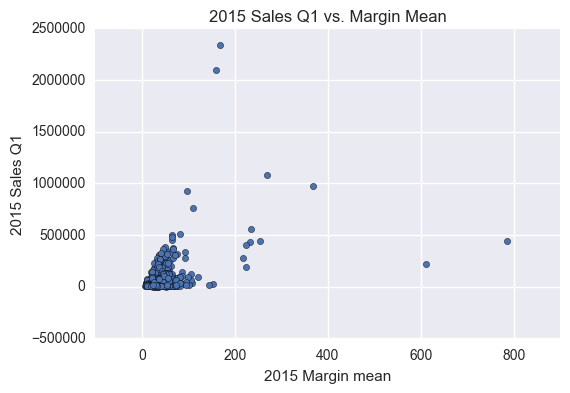

In [9]:
# exploratory analysis

# 2015 sales q1 v. margin mean
df2.plot.scatter(x='2015 Margin mean', y='2015 Sales Q1')
plt.title('2015 Sales Q1 vs. Margin Mean')
plt.show()

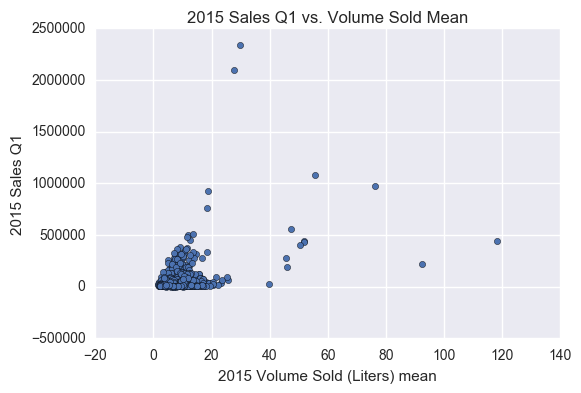

In [10]:
# 2015 sales q1 v. volume sold mean 
df2.plot.scatter(x='2015 Volume Sold (Liters) mean', y='2015 Sales Q1')
plt.title('2015 Sales Q1 vs. Volume Sold Mean')
plt.show()

#### Linear Regression

Model fit: 0.98490569032
4.23952836026 11566.7692834


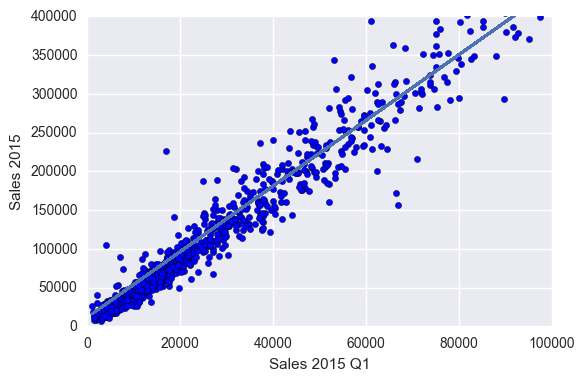

In [11]:
# fit a linear model

lm = linear_model.LinearRegression()
X = df2[['2015 Sales Q1']]
y = df2['2015 Sales']
lm.fit(X, y)
predictions = lm.predict(X)
print "Model fit:", lm.score(X, y)
print lm.coef_[0], lm.intercept_

plt.scatter(X, y)
plt.plot(X, predictions)
plt.xlabel("Sales 2015 Q1")
plt.ylabel("Sales 2015")
plt.xlim(0, 100000)
plt.ylim(0, 400000)
plt.show()

In [12]:
# predict 2016 sales

# fit linear model

X = df2[['2016 Sales Q1']]
predictions = lm.predict(X)
total_2016 = sum(predictions)
total_2015 = sum(df2['2015 Sales'])
X2 = df2[["2015 Sales Q1"]]
pred_2015 = sum(lm.predict(X2))

print "2015 predicted", pred_2015
print "2015 actual", total_2015
print "2016 predicted", total_2016

2015 predicted 270725844.17
2015 actual 270725844.17
2016 predicted 274353169.5


In [13]:
# city for better resolution

city = set(df2["City"].tolist())
models = dict()
all_predictions = []
coefficients = [[],[]]
for city in sorted(city):
    city_sales = df2[df2["City"] == city]
    lm = linear_model.LinearRegression()
    X = city_sales[["2015 Sales Q1"]]
    y = city_sales["2015 Sales"]
    lm.fit(X, y)
    models[city] = lm
    predictions2015 = lm.predict(X)
    X2 = city_sales[["2016 Sales Q1"]]
    predictions2016 = lm.predict(X2)
    all_predictions.append((sum(y), sum(predictions2015), sum(predictions2016)))
    if lm.score(X, y) > 0.8 and lm.score(X, y) < 1:
        coefficients[0].append(lm.coef_[0])
        coefficients[1].append(lm.intercept_)
print "Averaged model coefficients:", np.mean(coefficients[0]), np.mean(coefficients[1])


Averaged model coefficients: 4.53154772179 1327.02777134


1109
Model fit: 0.987579868264


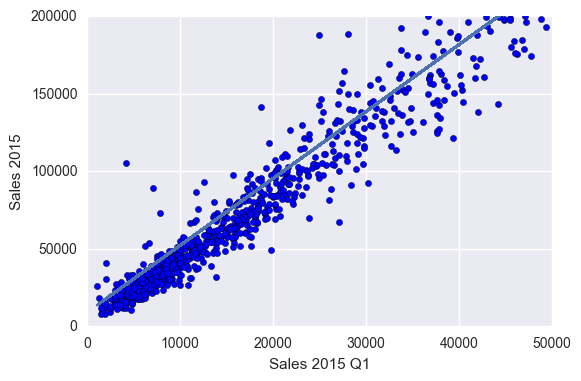

In [14]:
# filter stores that opened or closed throughout the year

lower_cutoff = pd.Timestamp("20150301")
upper_cutoff = pd.Timestamp("20151001")
mask = (df2['First Date'] < lower_cutoff) & (df2['Last Date'] > upper_cutoff)
df3 = df2[mask]

# fit linear model

lm = linear_model.LinearRegression()
X = df3[["2015 Sales Q1"]]
print len(X)
y = df3["2015 Sales"]
lm.fit(X, y)
predictions = lm.predict(X)
print "Model fit:", lm.score(X, y)


plt.scatter(X, y)
plt.plot(X, predictions)
plt.xlabel("Sales 2015 Q1")
plt.ylabel("Sales 2015")
plt.xlim(0, 50000)
plt.ylim(0, 200000)
plt.show()

In [15]:
# predict total sales for 2016 and compare 

X = df2[["2016 Sales Q1"]]
predictions = lm.predict(X)
total_2016 = sum(predictions)
total_2015 = sum(df2["2015 Sales"])
X2 = df2[["2015 Sales Q1"]]
pred_2015 = sum(lm.predict(X2))

print "2015 predicted", pred_2015
print "2015 actual", total_2015
print "2016 predicted", total_2016

2015 predicted 272617256.576
2015 actual 270725844.17
2016 predicted 276313274.605


1109


..........................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.4s finished


Model fit: 0.987578880684


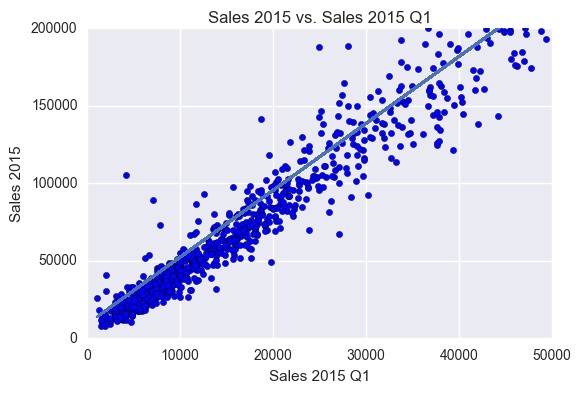

In [18]:
# regularization with elastic net 

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.cross_validation import cross_val_score
from sklearn import linear_model
from sklearn.metrics import r2_score

l1_ratios = np.linspace(0.01, 1.0, 5)
lm = linear_model.ElasticNetCV(l1_ratio=l1_ratios, n_alphas=10, cv=5,
                            verbose=1)
X = df3[["2015 Sales Q1"]]
print len(X)
y = df3["2015 Sales"]
lm.fit(X, y)
predictions = lm.predict(X)
print "Model fit:", lm.score(X, y)

plt.scatter(X, y)
plt.plot(X, predictions)
plt.xlabel("Sales 2015 Q1")
plt.ylabel("Sales 2015")
plt.title("Sales 2015 vs. Sales 2015 Q1")
plt.xlim(0, 50000)
plt.ylim(0, 200000)
plt.show()


In [17]:
X = df2[["2016 Sales Q1"]]
predictions = lm.predict(X)
total_2016 = sum(predictions)
total_2015 = sum(df2["2015 Sales"])
X2 = df3[["2015 Sales Q1"]]
pred_2015 = sum(lm.predict(X2))

print "2015 predicted", pred_2015
print "2015 actual", total_2015
print "2016 predicted", total_2016

2015 predicted 249796386.2
2015 actual 270725844.17
2016 predicted 276302299.602
